In [2]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [12]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine_final.csv', index_col=0)
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
# Number of errors
display(len(raw_data.loc[raw_data['errors']==1]))
display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

6

66

### Utils

In [5]:
def pca_plot(data, title, alpha):
    """ Function to perform dimensionality reduction on the features, so that we can create 2-dimensional scatterplots.
    Takes as input the entire dataset, selects the features on which we want to cluster, and stores them in a temporary pd Dataframe. 
    This df is used to create a seaborn scatterplot. """
    
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]
    
    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)
    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'Principal Component 1'}, inplace=True )
    temp_dataset.rename( columns={1 :'Principal Component 2'}, inplace=True )

    scatterplot = sns.scatterplot(data=temp_dataset, x='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="clusters", size='errors', sizes=(150, 30), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    # plt.savefig('germancredit_kmeans.png', dpi=300) # for saving a plot
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """ Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    ''' This function returns the value of a random cluster
    clusters Df.Column the column clusters '''
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    print('This is the random cluster we have picked:', result)
    return result

def plot_clusters(data):
    ''' This function returns a scatterplot of the clusters ''' 
    scatterplot = sns.scatterplot(data=data, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    ''' This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" '''
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. Cluster: ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    ''' This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are '''
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    ''' This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors '''
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    ''' This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    ''' This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters '''
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    print('discriminating bias is:', max_abs_bias)
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    ''' This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters '''
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: # Outliers in DBScan, which are excluded
            continue
        current_bias = (function(fulldata, cluster_number, "clusters")) # abs function to find the highest bias
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    print('cluster with the highest discriminating bias:', best_cluster)
    return best_cluster

def calculate_variance(data):
    ''' This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg '''
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    ''' Returns the size of the smallest new cluster '''
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware DBSCAN Clustering 

In [6]:
full_data = initialize_dataset(raw_data)
full_data.head()


# pca_plot(full_data, 'Compas', 0.6)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,-1
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,-1
118,-0.338510,1.005004,-1.166817,-0.803327,-1.246801,-0.988536,-0.762724,0.599286,-1.234524,-0.817815,-1.122366,-0.664518,-1.130778,0.8,2,1,1,0,-1
39,1.505019,1.494574,0.630750,-1.590260,1.470062,1.074278,0.907054,-1.248791,0.733019,-0.049584,-0.293318,1.298865,0.039721,0.0,0,0,0,0,-1
176,0.170050,0.270648,0.155921,0.320862,1.017252,-0.958422,-1.294440,1.402798,-0.242882,1.848400,-1.558707,-1.360753,0.281061,0.0,2,2,0,0,-1


Text(0.5, 1.0, 'Optimal Value of Epsilon for Wine')

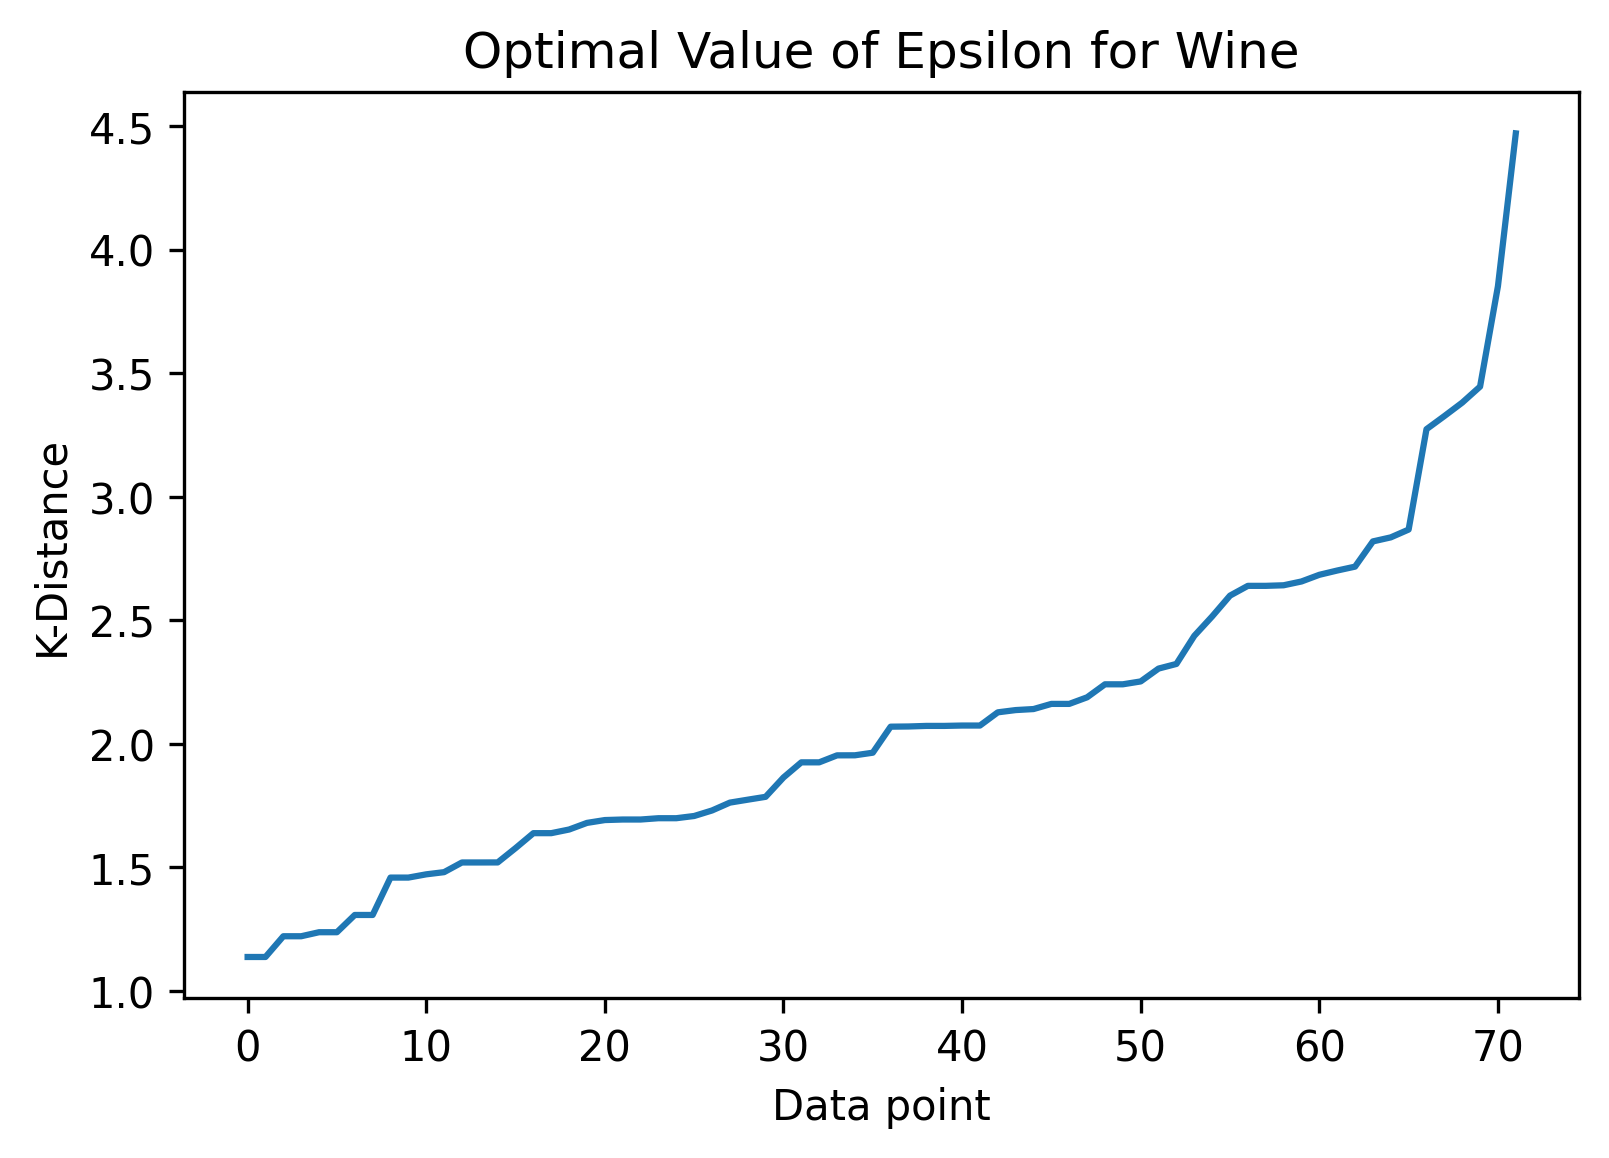

In [8]:
# determining epsilon
from sklearn.neighbors import NearestNeighbors

#for wine dataset
nn_features = full_data.iloc[: , : 14] #wine + including scaled errors
# for german credit:
# nn_features = full_data.iloc[: , : 25]

# for compas:
# nn_features = full_data.iloc[: , : 11]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Data point')
plt.ylabel('K-Distance')
plt.title('Optimal Value of Epsilon for Wine')

# plt.savefig('dbscan_wine_epsilon.png', dpi=300)

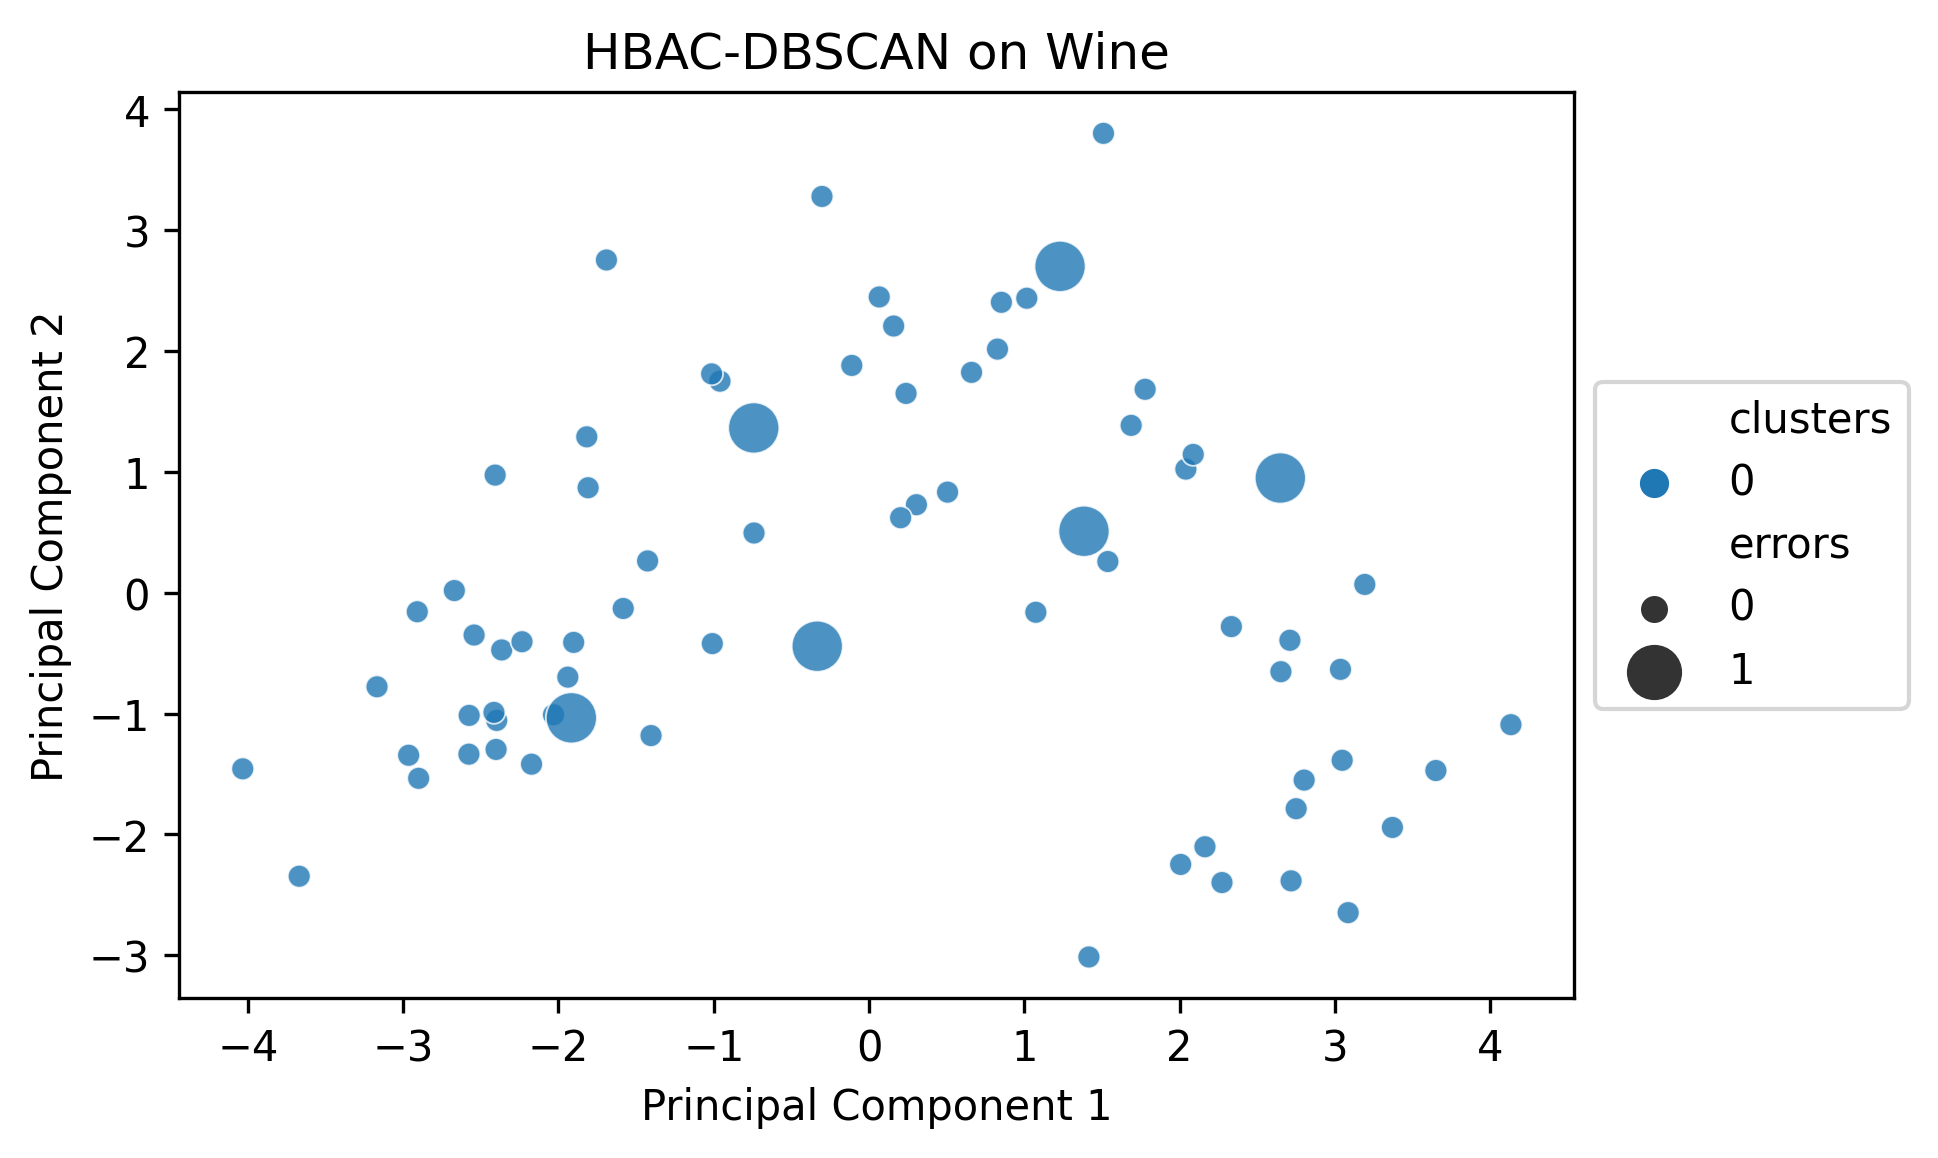

this is the current cluster:  0
discriminating bias is: -999999
smallest cluster:  3


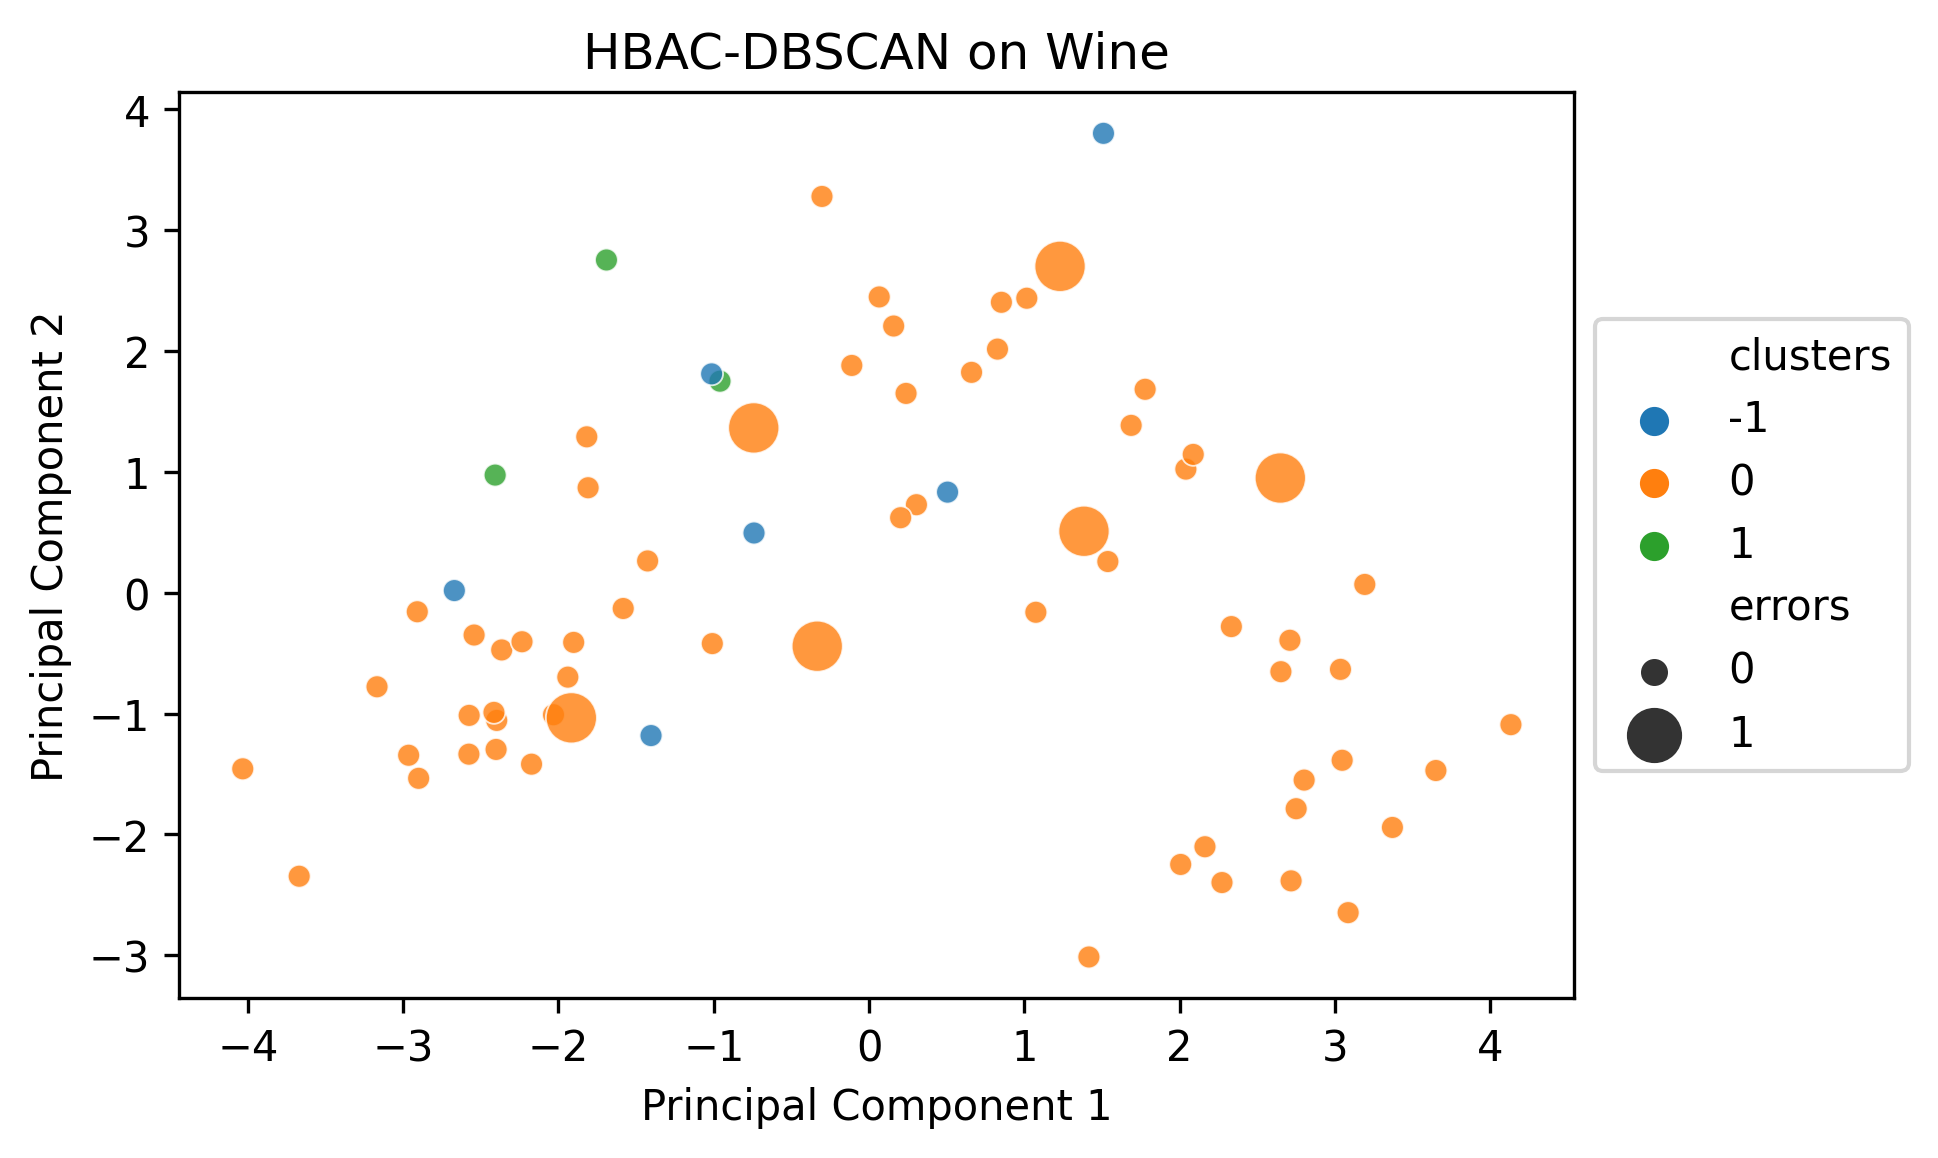

--> Cluster with the highest variance: 0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
MAX_ITER
0.9166666666666666
[0.00754014179655961, 0.00754014179

In [9]:
MAX_ITER = 30
epsilon =  3
minimum_samples = 3 # round(0.02 * len(full_data)) # 2*dim?
x = 0 # cluster number
initial_bias = 0
pca_plot(full_data, 'HBAC-DBSCAN on Wine', 0.8)
variance_list = []
minimal_splittable_cluster_size = round(0.03 * len(full_data))
minimal_acceptable_cluster_size = round(0.02 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon - 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    
    if (len(full_data['new_clusters'].unique()) <= 2): # to check whether a new cluster is found
        continue

    max_neg_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster: ", min_new_size)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        pca_plot(full_data, 'HBAC-DBSCAN on Wine', 0.8)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')
print(average_accuracy)
print(variance_list)

## Analysing the biased cluster

In [10]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

0 has bias -0.09523809523809523
1 has bias 0.08695652173913049
cluster with the highest discriminating bias: 0
General accuracy of classifier on this dataset: 0.9166666666666666
cluster 0 has the highest discrimination bias
-0.09523809523809523


Number of instances in discriminated cluster: 63
Number of errors in discriminated clusters:  6
found discriminated cluster:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315,proline,scaled_errors,predicted_class,true_class,errors,clusters,new_clusters
104,-0.669074,-0.481192,-1.166817,0.461386,-0.963795,-0.130285,-0.137723,-0.284577,-0.211402,-1.025689,0.361193,1.354564,-0.225753,0.0,1,1,0,0,0.0
67,-0.847070,-0.970763,-1.370315,0.208443,-1.360004,-0.265798,-0.063096,-0.686333,-0.903977,-0.239382,0.710266,1.229242,-0.714467,0.0,1,1,0,0,0.0
118,-0.338510,1.005004,-1.166817,-0.803327,-1.246801,-0.988536,-0.762724,0.599286,-1.234524,-0.817815,-1.122366,-0.664518,-1.130778,0.8,2,1,1,0,0.0
39,1.505019,1.494574,0.630750,-1.590260,1.470062,1.074278,0.907054,-1.248791,0.733019,-0.049584,-0.293318,1.298865,0.039721,0.0,0,0,0,0,0.0
176,0.170050,0.270648,0.155921,0.320862,1.017252,-0.958422,-1.294440,1.402798,-0.242882,1.848400,-1.558707,-1.360753,0.281061,0.0,2,2,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0.691323,-0.542389,0.122005,0.067920,0.224833,0.863479,1.046980,-1.088089,0.528395,0.763838,0.579364,0.393760,2.317367,0.0,0,0,0,0,0.0
12,0.907461,-0.481192,0.291586,-0.803327,-0.737389,0.471996,0.645860,-0.525631,0.308030,0.176367,0.841168,0.421609,1.729100,0.0,0,0,0,0,0.0
47,1.098171,-0.524904,-0.691988,-0.803327,-0.058174,1.224848,1.233547,-1.168440,0.827461,0.402317,-0.206050,1.020371,0.718489,0.0,0,0,0,0,0.0
8,2.280572,-0.559873,-0.522406,-1.365422,-0.284579,0.773137,0.851084,-0.525631,0.575616,-0.004393,0.535730,0.351986,0.899494,0.0,0,0,0,0,0.0


alcohol
this is the t-statistic 5.539882670944636
this is the p-value: 3.7724205064935356e-05
malic_acid
this is the t-statistic 0.8181546679583159
this is the p-value: 0.4311787357901682
ash
this is the t-statistic 0.3284603178249884
this is the p-value: 0.7505536617762093
alcalinity_of_ash
this is the t-statistic -0.6338900739934928
this is the p-value: 0.5426821506979184
magnesium
this is the t-statistic -2.2952670803057886
this is the p-value: 0.04905178907661853
total_phenols
this is the t-statistic -0.8058663809290654
this is the p-value: 0.43771700336066466
flavanoids
this is the t-statistic -0.6254817900299074
this is the p-value: 0.5466000024552748
nonflavanoid_phenols
this is the t-statistic 1.8261047896625808
this is the p-value: 0.09648764943900859
proanthocyanins
this is the t-statistic -2.33606913088068
this is the p-value: 0.044524906251930875
color_intensity
this is the t-statistic 5.043122756879565
this is the p-value: 9.928790127204593e-05
hue
this is the t-statistic 

,unscaled_discriminated,unscaled_remaining,difference
alcohol,13.154127,12.211111,0.943016
malic_acid,2.321111,1.995556,0.325556
ash,2.331746,2.270000,0.061746
alcalinity_of_ash,18.692063,20.022222,-1.330159
magnesium,99.158730,122.111111,-22.952381
total_phenols,2.263651,2.446667,-0.183016
flavanoids,2.030476,2.327778,-0.297302
nonflavanoid_phenols,0.365397,0.285556,0.079841
proanthocyanins,1.526349,2.230000,-0.703651
color_intensity,5.513492,3.083333,2.430159


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315,proline,predicted_class,true_class,errors,index
unscaled_discriminated,13.154127,2.321111,2.331746,18.692063,99.158730,2.263651,2.030476,0.365397,1.526349,5.513492,0.936667,2.559524,761.682540,0.936508,0.904762,0.095238,unscaled_discriminated
unscaled_remaining,12.211111,1.995556,2.270000,20.022222,122.111111,2.446667,2.327778,0.285556,2.230000,3.083333,1.101111,2.861111,642.888889,1.000000,1.000000,0.000000,unscaled_remaining


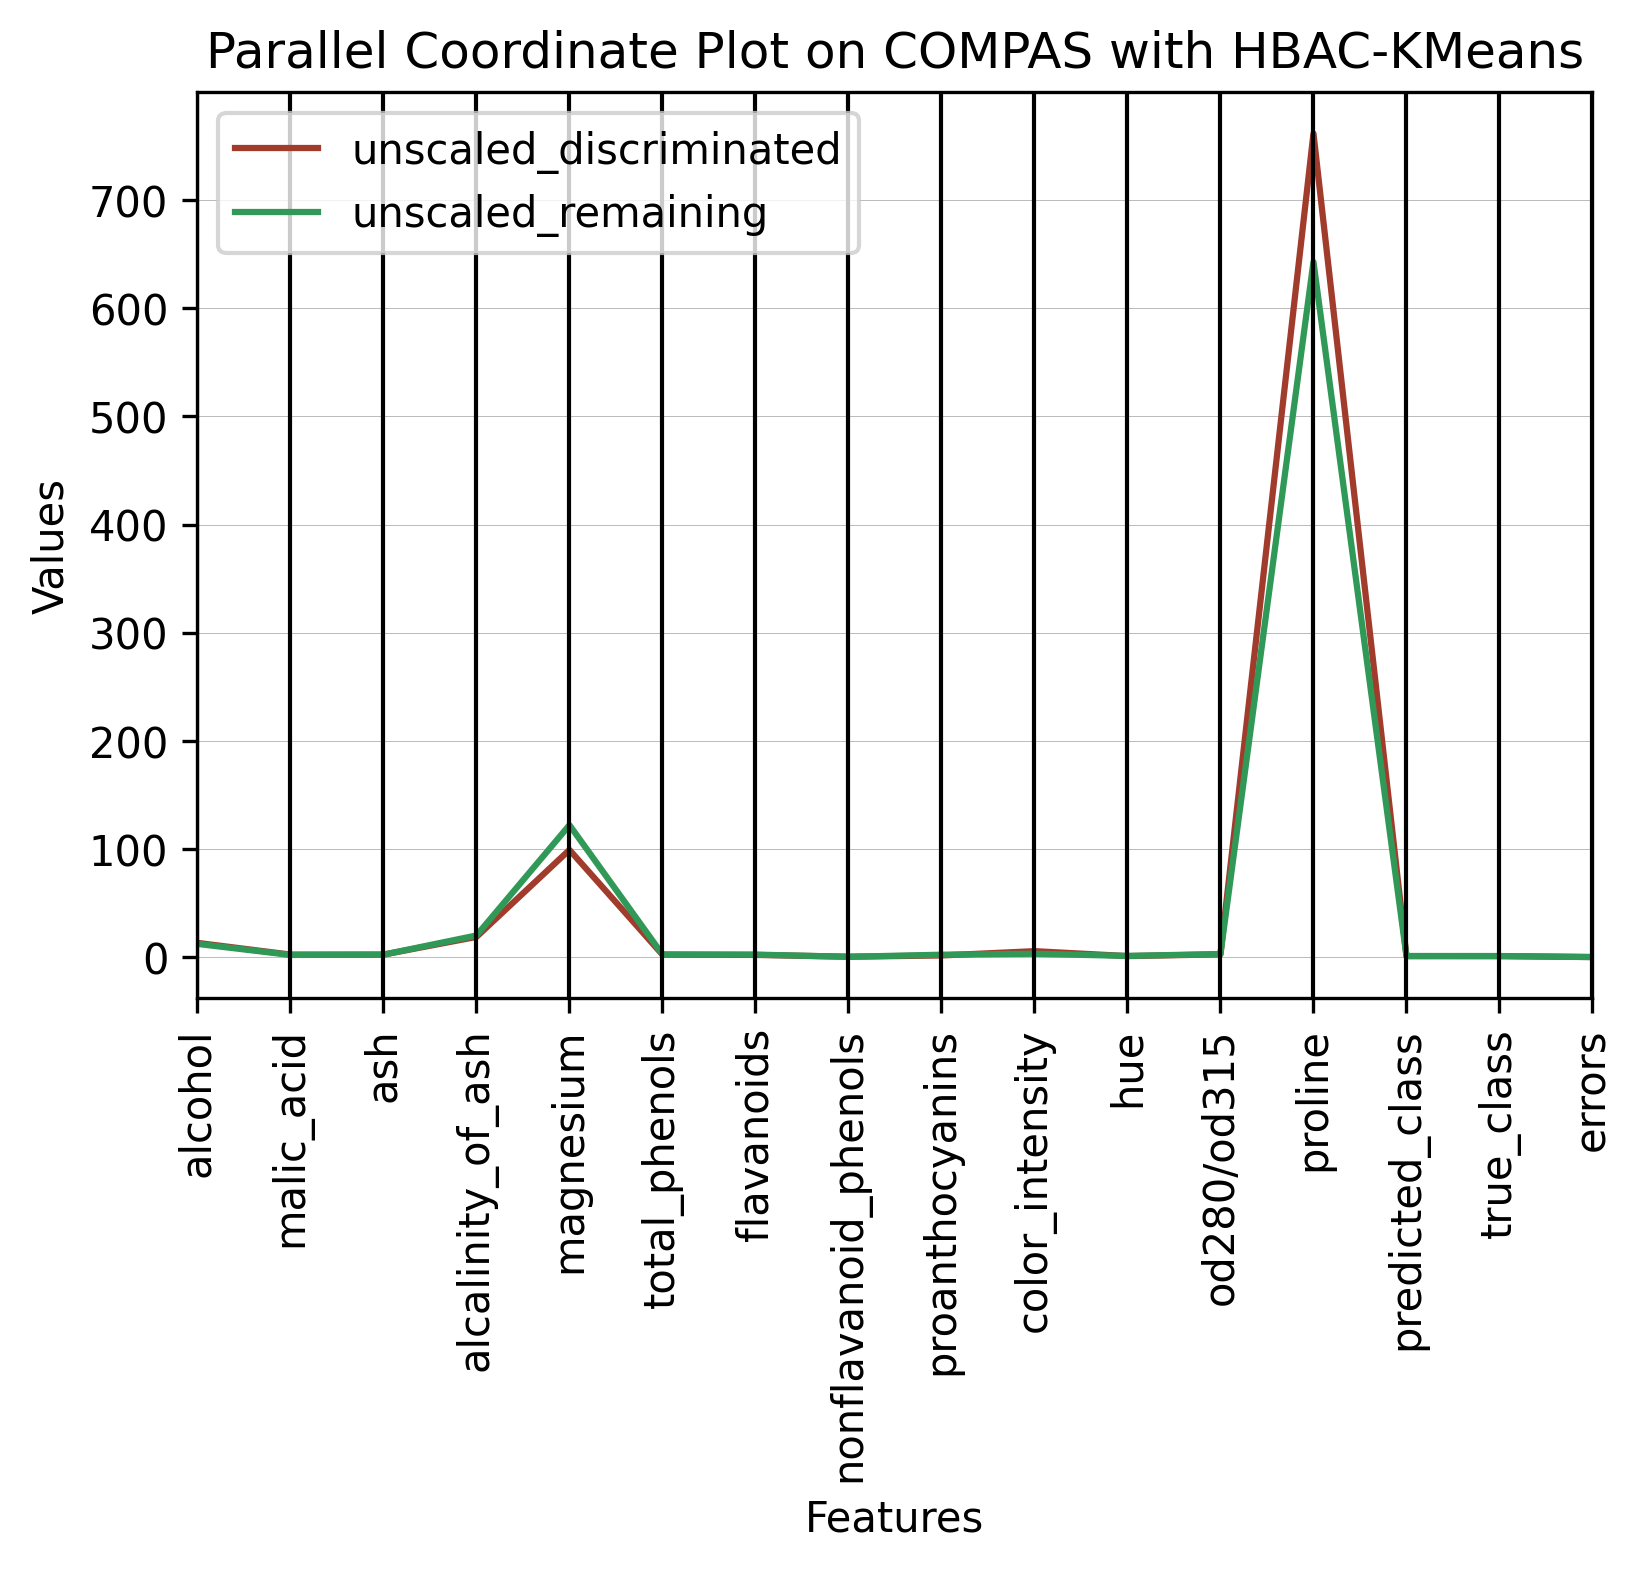

In [11]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on COMPAS with HBAC-KMeans")

## Seaborn Density Plots

In [13]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315,proline,predicted_class,true_class,errors,bias
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0,1,1,0,discriminated
67,12.37,1.17,1.92,19.6,78.0,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510.0,1,1,0,discriminated
118,12.77,3.43,1.98,16.0,80.0,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372.0,2,1,1,discriminated
39,14.22,3.99,2.51,13.2,128.0,3.00,3.04,0.20,2.08,5.10,0.89,3.53,760.0,0,0,0,discriminated
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2,2,0,discriminated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,13.58,1.66,2.36,19.1,106.0,2.86,3.19,0.22,1.95,6.90,1.09,2.88,1515.0,0,0,0,discriminated
12,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0,0,0,0,discriminated
47,13.90,1.68,2.12,16.0,101.0,3.10,3.39,0.21,2.14,6.10,0.91,3.33,985.0,0,0,0,discriminated
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0,0,0,discriminated


In [14]:
df_all.columns
welchtest = pd.DataFrame()
welchtest = df_all[['alcohol', 'color_intensity', 'bias']]
welchtest.columns

Index(['alcohol', 'color_intensity', 'bias'], dtype='object')

1
2


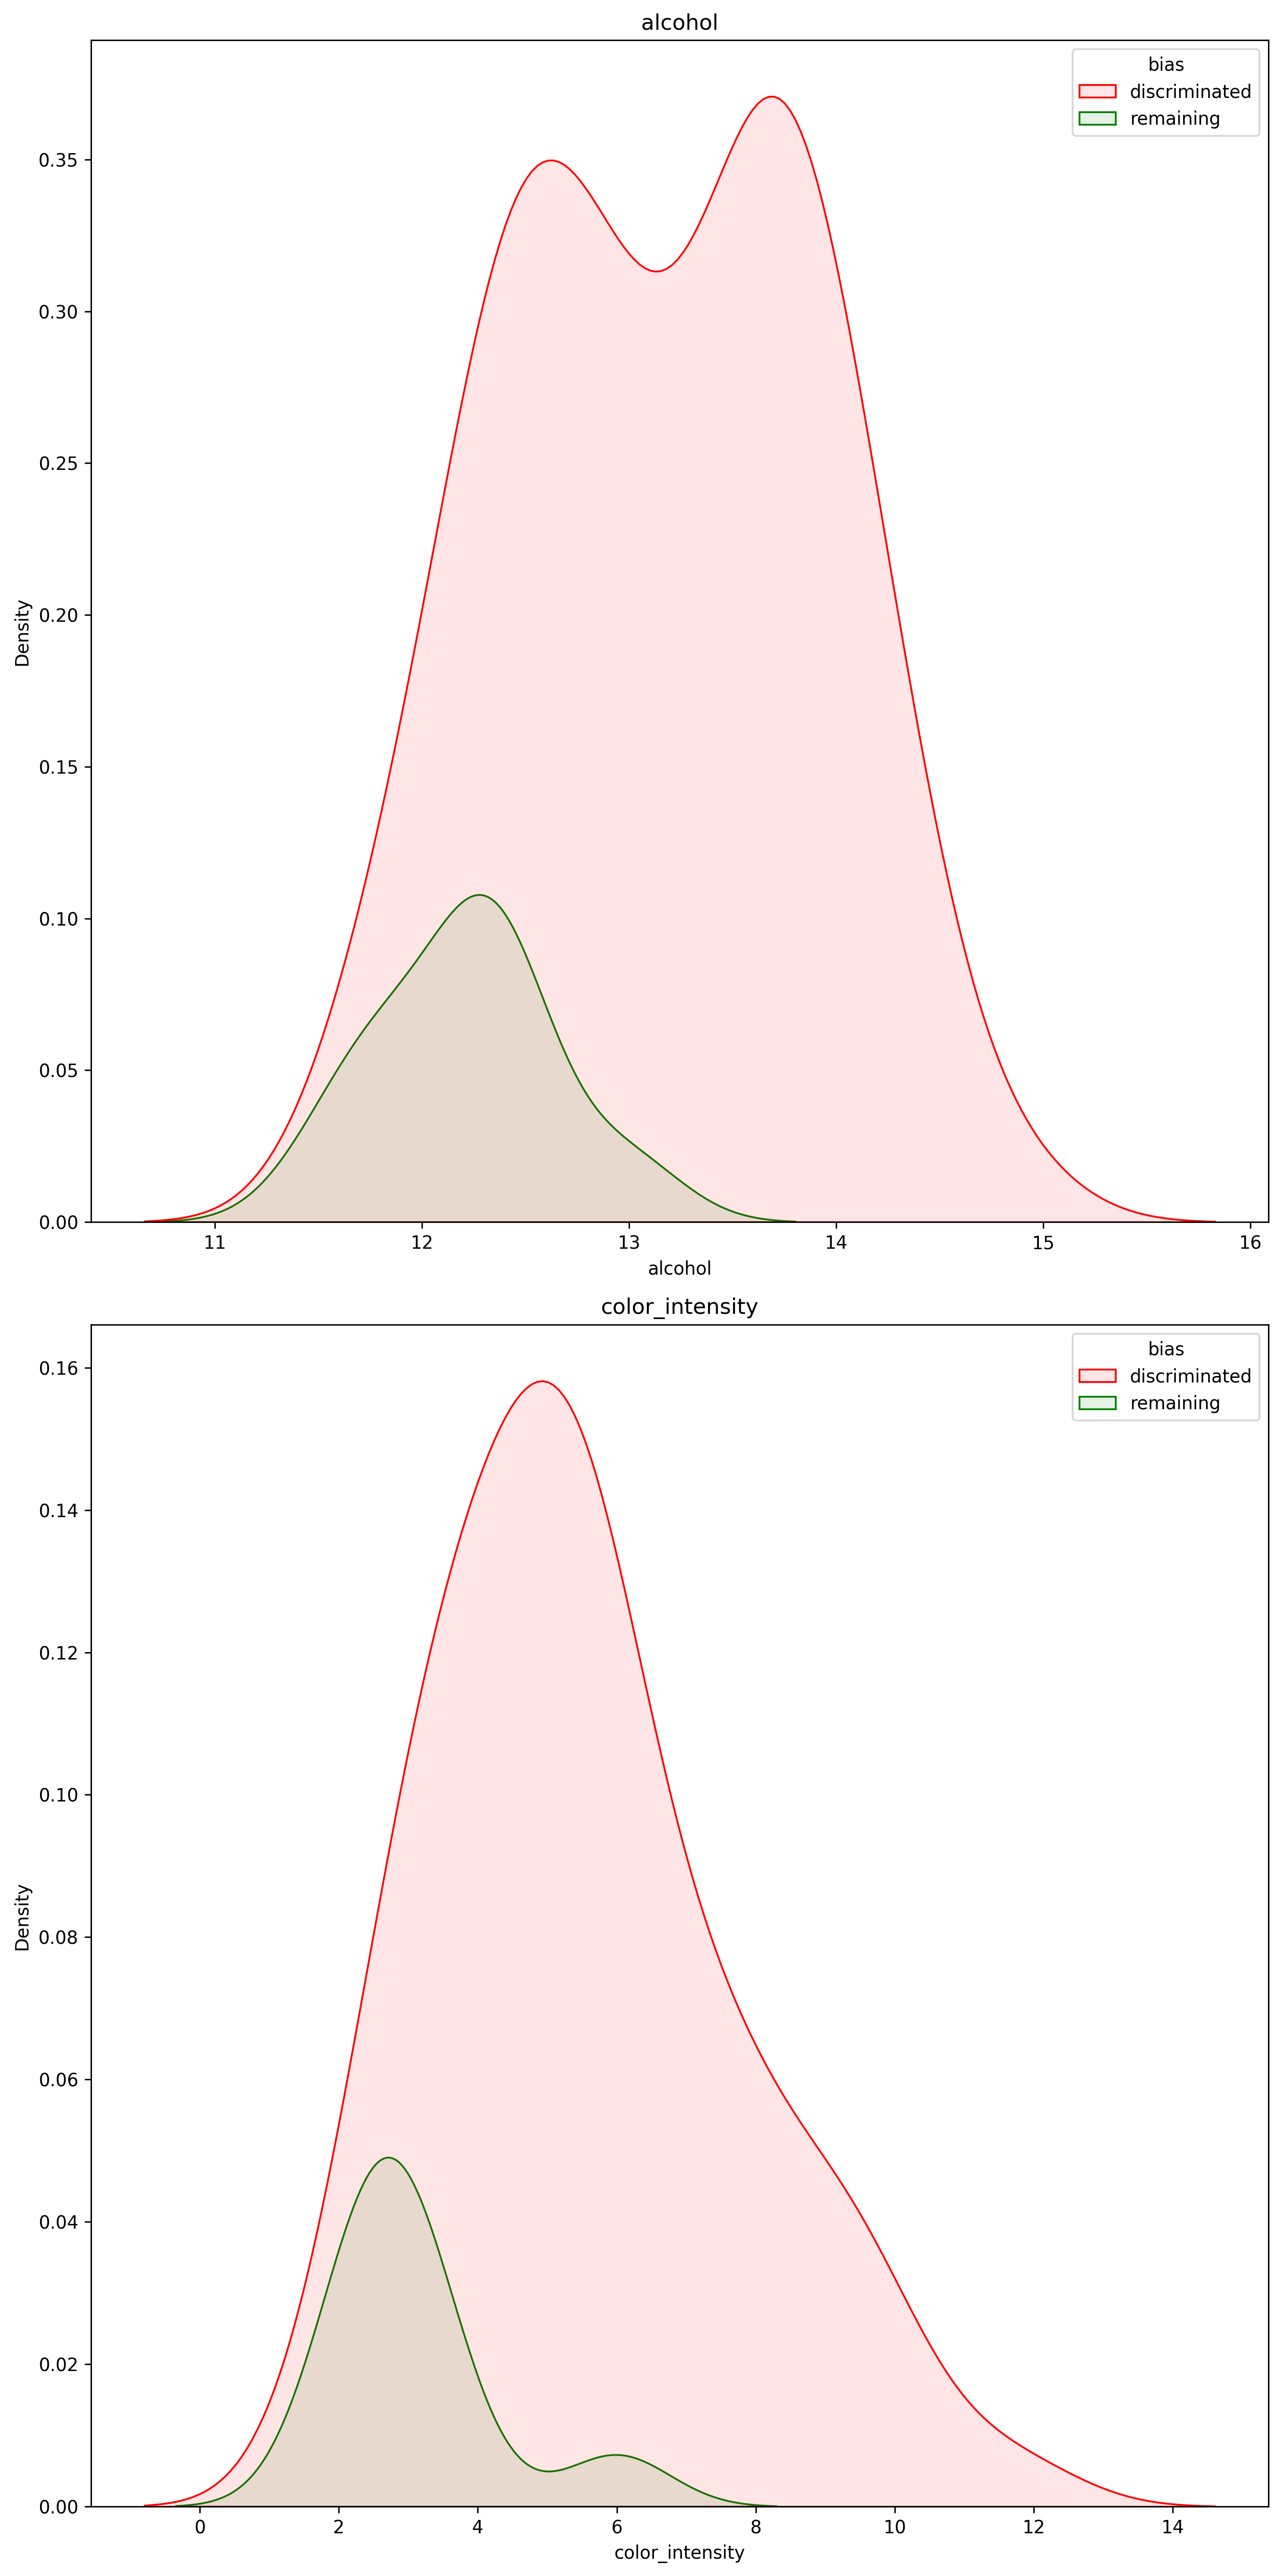

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()



1
2


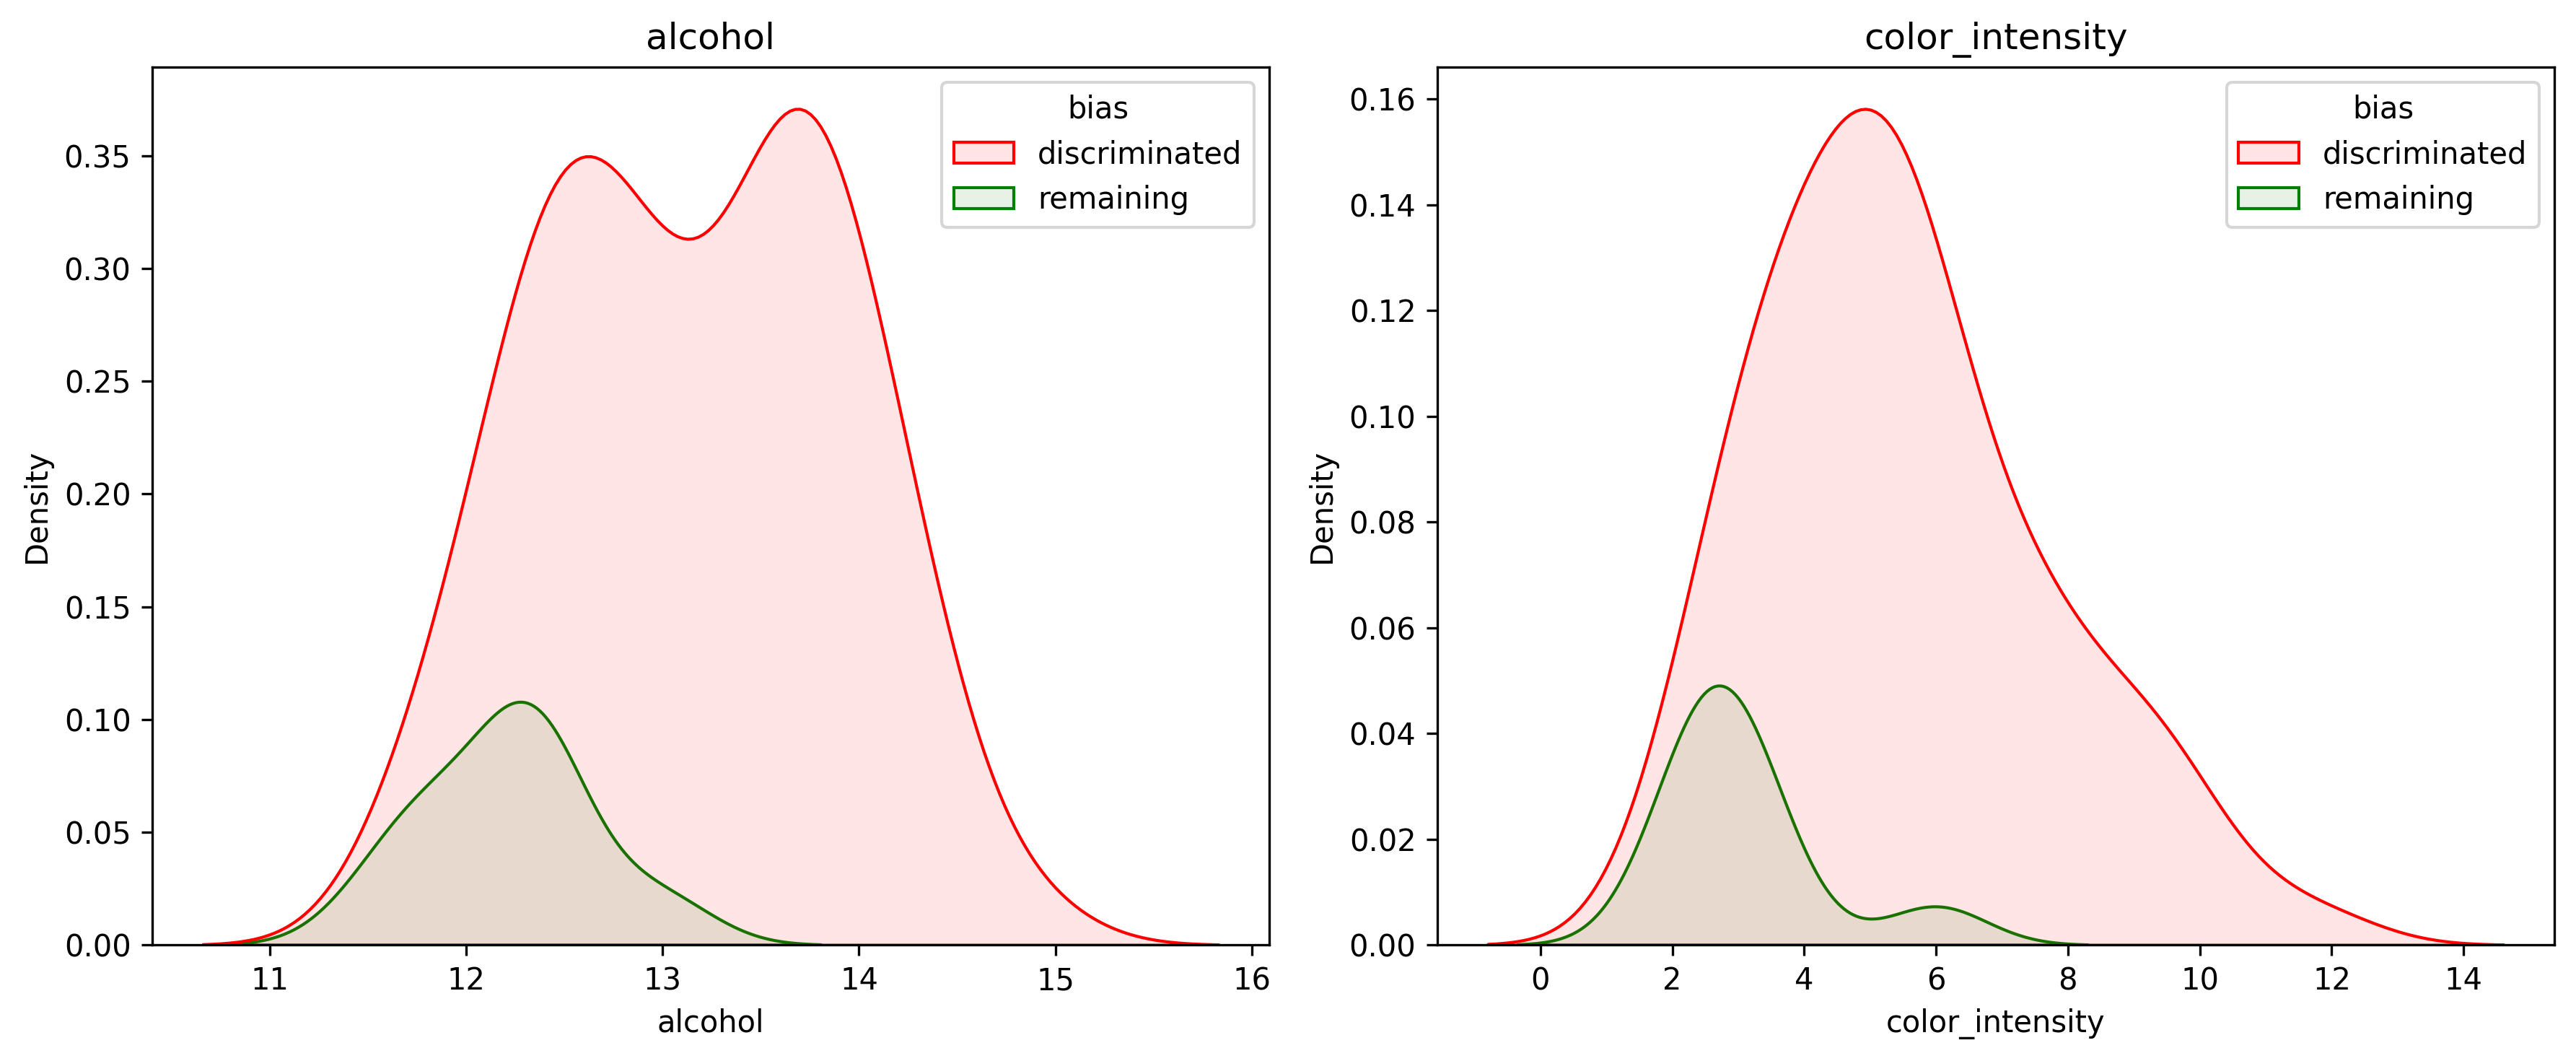

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()


## Plotly 

In [22]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors,bias
3195,2,0,0,0,0,0,0,0,1,0,1,0,1,1,discriminated
2252,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
3679,0,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
2524,1,0,0,1,0,0,0,0,1,0,0,0,1,1,discriminated
5140,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2,0,0,0,0,0,0,0,1,0,0,0,1,1,discriminated
4258,2,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
6078,0,0,0,0,0,0,0,0,1,0,1,0,0,0,discriminated
4175,0,1,0,0,0,0,0,0,1,0,0,1,1,0,discriminated


In [19]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200)
x2 = np.random.randn(200) + 2

group_labels = ['Group 1', 'Group 2']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

## Seaborn Pairplot / Density plot

In [24]:
sns.pairplot(df_all, hue="bias")

MemoryError: In RendererAgg: Out of memory

MemoryError: In RendererAgg: Out of memory

<Figure size 10500x10500 with 196 Axes>